### Task 1

#### 1. Basic Concepts
1. The purpose of using dataset distillation in this paper is to reduce the training costs while maintaining the high performance on various machine learning tasks. The authors introduce Dataset Distillation with Attention Maching (DataDAM) to condense large datasets into smaller synthetic dataset that retain the critical information, allowing models trained on the synthetic set to achieve similar accuracy as those trained on the full dataset.
2.  The advantages are: (page 2)
- Efficient end-to-end dataset distillation: This highlights the ability of DataDAM to closely approximate the distribution of the real dataset while keeping **computational costs low**.
- Improved accuracy and scalability: DataDAM demonstrate the performance across multiple benchmark dataset and reduces the training costs by up to 100x, while also allowing for cross-architecture generation. This makes it more scalable and flexible for real-world application.
- Enhancement of downstream application: DATADAM's distilled data improves memory efficiency in continual learning tasks and accelerates neural architectures search(NAS) by providing a more representative proxy dataset, enabling a faster and more efficient learning process.  
3. The novelty includes: (page 2)
- Multiple Randomly Initialized DNNs: DataDAM uses multiple randomly initialized deep neural networks to extract meaningful representations from both real and synthetic datasets, which is different from methods that rely on pre-trained models
- Spatial attention matching (SAM): The SAM module align the most discriminative feature maps from real and synthetic datasets, reducing the gap between the dataset.
- Last-Layer Feature Alignment: It reduces disparities in the last-layer feature distributions between the real and synthetic datasets by using a complementary loss as a regularizer, ensuring high-level abstract representations are similar.
- Bias-Free Synthetic Data: The synthetic data generated by DataDAM does not introduce any bias, which is a significant improvement over prior methods, ensuring better generalization and performance.
4. The methodology of DataDAM is centered on efficiently distilling datasets through attention matching: (page 4)
- Initialization of Synthetic Dataset: The process starts by initializing a synthetic dataset, which can be done through random noise or by sampling real data.
- Feature Extraction: Real and synthetic datasets are passed through randomly initialized deep neural networks, and features are extracted at multiple layers.
- Spatial Attention Matching (SAM): Attention maps are computed for each layer, excluding the final layer. These attention maps focus on the most discriminative regions of the input image. 
- Loss Functions:
    - SAM Loss (LSAM): This loss minimizes the distance between attention maps of real and synthetic datasets across layers.
    - Maximum Mean Discrepancy Loss (MMD): This complementary loss aligns the last-layer feature distributions of the two datasets, ensuring the high-level abstract information is captured.
- Optimization: The synthetic dataset is optimized using a combination of the SAM loss and LMMD loss to minimize the difference between real and synthetic data.
5. (page 8)
- Continual Learning: DataDAM’s ability to condense datasets efficiently makes it highly useful in continual learning scenarios, where a model must learn incrementally while preventing catastrophic forgetting. By using the distilled datasets as a replay buffer, DataDAM can significantly improve memory efficiency and performance in incremental learning tasks.
- Neural Architecture Search (NAS): The synthetic datasets generated by DataDAM can serve as proxies in NAS tasks, allowing faster evaluation of model architectures. This leads to a significant reduction in computational costs and time during the model search process, making NAS more feasible in real-world applications.

#### 2. Data Distillation Learning - MHIST
##### a) Train model with origianl dataset


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
import import_ipynb
from utils import get_network, get_time

In [3]:
train_folder = 'mhist_dataset/train'
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224)) 
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=20)
criterion = torch.nn.CrossEntropyLoss()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def training_model(model, optimizer, scheduler, criterion, train_loader):
    torch.cuda.empty_cache()
    for epoch in range(20):
        model.train()
        
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            torch.cuda.empty_cache()
        scheduler.step()
        
        print(f"Epoch [{epoch+1}/20], Loss: {running_loss / len(train_loader.dataset)}")


In [7]:
training_model(model, optimizer, scheduler, criterion, train_loader)

Epoch [1/20], Loss: 0.6219259958157595
Epoch [2/20], Loss: 0.5397951640616888
Epoch [3/20], Loss: 0.4724099570718305
Epoch [4/20], Loss: 0.4646555024179919
Epoch [5/20], Loss: 0.3956897972918105
Epoch [6/20], Loss: 0.3369082581037762
Epoch [7/20], Loss: 0.30495496458020704
Epoch [8/20], Loss: 0.23932631855723502
Epoch [9/20], Loss: 0.1936680019792469
Epoch [10/20], Loss: 0.1605644382039706
Epoch [11/20], Loss: 0.08894110589534387
Epoch [12/20], Loss: 0.04703387036748316
Epoch [13/20], Loss: 0.02272323851441515
Epoch [14/20], Loss: 0.013110558872764138
Epoch [15/20], Loss: 0.009531328112058255
Epoch [16/20], Loss: 0.007783463616780509
Epoch [17/20], Loss: 0.007001087275686962
Epoch [18/20], Loss: 0.006504435736643172
Epoch [19/20], Loss: 0.006287433406145408
Epoch [20/20], Loss: 0.006184749263713415


In [8]:
model_path = 'models/mhist_original.pth'
torch.save(model.state_dict(), model_path)

In [9]:
model_path = 'models/mhist_original.pth'
model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224)) 
model.load_state_dict(torch.load(model_path))


C:\Users\ruby\AppData\Local\Temp\ipykernel_9812\2603459081.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader):
    model.to(device)
    model.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          labels = labels.long()
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [13]:
evaluate_model(model, test_loader)

Test Accuracy: 80.86%


In [15]:
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"MACs: {macs}, Parameters: {params}")

ConvNet(
  891.14 k, 100.000% Params, 2.68 GMac, 99.365% MACs, 
  (features): Sequential(
    890.88 k, 99.971% Params, 2.68 GMac, 99.365% MACs, 
    (0): Conv2d(3.58 k, 0.402% Params, 179.83 MMac, 6.664% MACs, 3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(256, 0.029% Params, 12.85 MMac, 0.476% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 6.42 MMac, 0.238% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 6.42 MMac, 0.238% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 16.561% Params, 1.85 GMac, 68.604% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.029% Params, 3.21 MMac, 0.119% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 1.61 MMac, 0.060% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 1.61 MMac, 0.060% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 16.561% Params, 462.82 MMac, 17.151% MACs, 128,

In [16]:
total_flops = 0

for inputs, labels in test_loader:
    total_flops += get_model_complexity_info(model, (3, 224, 224), as_strings=False)[0]

print(f"Total FLOPs for the test dataset: {total_flops}")

ConvNet(
  891.14 k, 100.000% Params, 2.68 GMac, 99.365% MACs, 
  (features): Sequential(
    890.88 k, 99.971% Params, 2.68 GMac, 99.365% MACs, 
    (0): Conv2d(3.58 k, 0.402% Params, 179.83 MMac, 6.664% MACs, 3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(256, 0.029% Params, 12.85 MMac, 0.476% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 6.42 MMac, 0.238% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 6.42 MMac, 0.238% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 16.561% Params, 1.85 GMac, 68.604% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.029% Params, 3.21 MMac, 0.119% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 1.61 MMac, 0.060% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 1.61 MMac, 0.060% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 16.561% Params, 462.82 MMac, 17.151% MACs, 128,

##### b) Learn the synthetic dataset with attention matching algorithm

In [17]:
# step 4: real dataset loader 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

real_dataset = datasets.ImageFolder(root='mhist_dataset/train', transform=transform)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=128, shuffle=True)


In [40]:
# set up the synthetic dataset 
import random

num_classes = 2 
num_images_per_class = 50 
img_size = (3, 224, 224)

def generate_synthetic_dataset_with_noise(real_dataset, num_classes, images_per_class=50, noise_std=0.8):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):
        # Randomly sample 50 images from each class
        indices = random.sample(
            [i for i, (_, label) in enumerate(real_dataset) if label == class_id],
            images_per_class
        )

        for i in indices:
            img_real = real_dataset[i][0]
            noise = torch.rand(size=img_real.shape)

            noise = noise.to(img_real.device)

            synthetic_image = img_real + noise

            synthetic_image = torch.clamp(synthetic_image, 0, 1)

            synthetic_images.append(synthetic_image)
            synthetic_labels.append(real_dataset[i][1])

    
    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels)

    return img_syn, labels_syn

In [41]:
#step 2: optimizer 
img_syn, _ = generate_synthetic_dataset_with_noise(real_dataset, num_classes)

img_syn = torch.nn.Parameter(img_syn)
optimizer_img = optim.SGD([img_syn], lr=0.1)  # lr is eta_s


In [42]:
# step 3: set up model - ConvNET - 7 in this case 
# freeze the model's weights so that only the synthetic dataset is updated 
model_path = 'models/mhist_original.pth'
net = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224)) 
net.load_state_dict(torch.load(model_path))
net.train()

for param in list(net.parameters()):
    param.requires_grad = False

In [43]:
# step 5: hook
# Using hook to extract the activations from the layers (attention maps) to compare the attention maps from real to synthetic
activations = {}

def get_activation(name):
    def hook_func(m, inp, op):
        activations[name] = op.detach()

    return hook_func


''' Defining the Refresh Function to store Activations and reset Collection '''


def refresh_activations(activations):
    model_set_activations = []  # Jagged Tensor Creation
    for i in activations.keys():
        model_set_activations.append(activations[i])
    activations = {}
    return activations, model_set_activations


def delete_hooks(hooks):
    for i in hooks:
        i.remove()
    return


def attach_hooks(net):
    hooks = []
    for name, module in net.named_modules():
        if isinstance(module, nn.ReLU):
            hooks.append(module.register_forward_hook(get_activation(name)))
    return hooks

In [44]:
# step 6: Attention Matching Map
def get_attention(feature_set, param=0, exp=4, norm='l2'):
    if param==0:
        attention_map = torch.sum(torch.abs(feature_set), dim=1)
    
    elif param ==1:
        attention_map =  torch.sum(torch.abs(feature_set)**exp, dim=1)
    
    elif param == 2:
        attention_map =  torch.max(torch.abs(feature_set)**exp, dim=1)
    
    if norm == 'l2': 
        # Dimension: [B x (H*W)] -- Vectorized
        vectorized_attention_map =  attention_map.view(feature_set.size(0), -1)
        normalized_attention_maps = F.normalize(vectorized_attention_map, p=2, dim=1)

    return normalized_attention_maps

In [45]:
# step 7: error function
def error(real, syn, err_type="MSE"):
    if err_type == "MSE":
        err = torch.sum((torch.mean(real, dim=0) - torch.mean(syn, dim=0)) ** 2)
    elif err_type == "MAE":
        err = torch.sum(torch.abs(torch.mean(real, dim=0) - torch.mean(syn, dim=0)))
    elif err_type == "MSE_B":
        err = torch.sum(
            (torch.mean(real.reshape(2, -1).cpu(), dim=1) - torch.mean(syn.reshape(2, -1).cpu(), dim=1)) ** 2)
    else:
        raise ValueError("Invalid error type")
    return err

In [46]:
# step 8: training loop
def train_dataset(img_syn, labels_syn, activations={}):
    num_iterations = 2
    learning_rate_model = 0.01


    losses = []
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")

        images_syn_all = []
        labels_syn_all = []
        images_real_all = []
        labels_real_all = []

        for c in range(num_classes):
            img_real, label_real = next(iter(real_loader))
            img_real = img_real.to(device)
            img_syn_per_class = img_syn[c * num_images_per_class:(c + 1) * num_images_per_class].to(device)
            label_syn_per_class = labels_syn[c * num_images_per_class:(c + 1) * num_images_per_class]

            images_real_all.append(img_real)
            labels_real_all.append(label_real)
            images_syn_all.append(img_syn_per_class)
            labels_syn_all.append(label_syn_per_class)

        images_real_all = torch.cat(images_real_all, dim=0)
        labels_real_all = torch.cat(labels_real_all, dim=0)
        images_syn_all = torch.cat(images_syn_all, dim=0)
        labels_syn_all = torch.cat(labels_syn_all, dim=0)

        net.train()
        hooks = attach_hooks(net)

        output_real = net(images_real_all)[0]
        activations, original_model_set_activations = refresh_activations(activations)

        output_syn = net(images_syn_all)[0]
        activations, syn_model_set_activations = refresh_activations(activations)
        delete_hooks(hooks)

        length_of_network = len(original_model_set_activations)

        loss = torch.tensor(0.0)
        mid_loss = 0
        out_loss = 0
        loss_avg = 0

        for layer in range(length_of_network - 1):
            real_attention = get_attention(original_model_set_activations[layer], param=1, exp=1, norm='l2')
            syn_attention = get_attention(syn_model_set_activations[layer], param=1, exp=1, norm='l2')

            tl = 100 * error(real_attention, syn_attention, err_type="MSE_B")
            loss += tl
            mid_loss += tl.item()

        output_loss = 100 * 0.01 * error(output_real, output_syn, err_type="MSE_B")
        loss += output_loss
        out_loss += output_loss.item()

        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step()
        loss_avg += loss.item()
        torch.cuda.empty_cache()

        loss_avg /= (num_classes)
        out_loss /= (num_classes)
        mid_loss /= (num_classes)
        losses.append((loss_avg, out_loss, mid_loss))
        if iteration % 10 == 0:
            print('%s iter = %05d, loss = %.4f' % (get_time(), iteration, loss_avg))

    print("training completed.")
    return img_syn, labels_syn, losses

In [47]:
def save_results(img_syn, losses, noise_type):
    save_path = f"mhist_result/{noise_type}_synthetic_dataset.pt"

    torch.save(img_syn, save_path)

    print(f"Synthetic dataset saved to {save_path}")

    loss_log_path = f"mhist_result/{noise_type}_training_losses.txt"
    with open(loss_log_path, "w") as f:
        for epoch, loss in enumerate(losses):
            f.write(f"Iteration {epoch}: Loss = {loss}\n")

    print(f"Training losses saved to {loss_log_path}")

In [ ]:
img_syn, losses = train_dataset(img_syn)
save_results(img_syn, losses, 'Random')

Iteration 1/200
[2024-10-23 01:19:31] iter = 00000, loss = 0.7326
Iteration 2/200
Iteration 3/200
Iteration 4/200
Iteration 5/200
Iteration 6/200
Iteration 7/200
Iteration 8/200
Iteration 9/200
Iteration 10/200
Iteration 11/200
[2024-10-23 01:55:34] iter = 00010, loss = 6.6751
Iteration 12/200
Iteration 13/200
Iteration 14/200
Iteration 15/200
Iteration 16/200
Iteration 17/200
Iteration 18/200
Iteration 19/200
Iteration 20/200
Iteration 21/200
[2024-10-23 02:26:35] iter = 00020, loss = 0.7770
Iteration 22/200
Iteration 23/200
Iteration 24/200


##### 2c) Visualize the condensed images per class

In [32]:
import torch
import os
import matplotlib.pyplot as plt

def display_image_grid(img_syn, labels_syn, noise_type):
    # Create directory to save grid images
    save_dir = f"mhist_result/{noise_type}_grid"
    os.makedirs(save_dir, exist_ok=True)

    num_samples_per_class = 50

    class_dict = {}
    
    for img, label in zip(img_syn, labels_syn):
        label = label.item() 
        if label not in class_dict:
            class_dict[label] = []
        class_dict[label].append(img)

    for class_label, images in class_dict.items():
        selected_images = images[:num_samples_per_class]
        
        fig, axs = plt.subplots(5, 10, figsize=(15, 7)) 
        fig.suptitle(f"Class {class_label} - {noise_type}", fontsize=16)
        fig.patch.set_facecolor('white')

        # Display each image
        for idx, img in enumerate(selected_images):
            img_np = img.permute(1, 2, 0).detach().numpy() 
            axs[idx // 10, idx % 10].imshow(img_np)
            axs[idx // 10, idx % 10].axis('off')
            axs[idx // 10, idx % 10].set_facecolor('white')  

        # Display the grid of images
        plt.show()

        # Save the grid of images as a single image file for report
        grid_save_path = os.path.join(save_dir, f"class_{class_label}_grid.png")
        fig.savefig(grid_save_path, facecolor='white')  # Save grid with white background
        plt.close()

    print(f"Image grids saved to {save_dir}")

# Call the function with your loaded data

Images shape: torch.Size([100, 3, 224, 224])
Labels shape: torch.Size([100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0062037795..1.1878685].


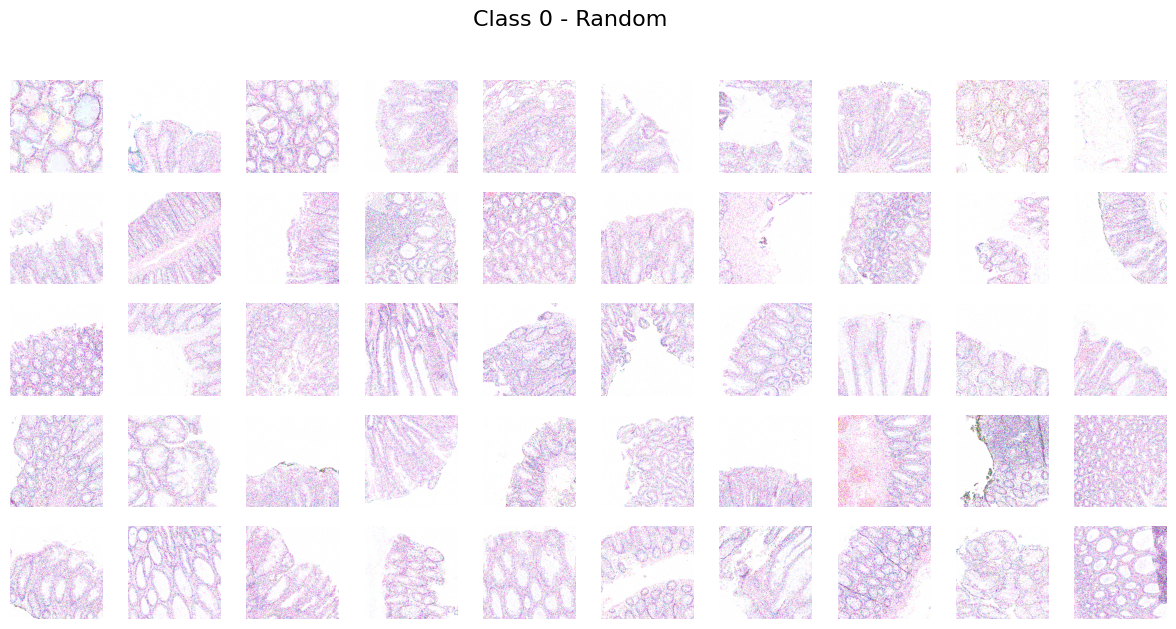

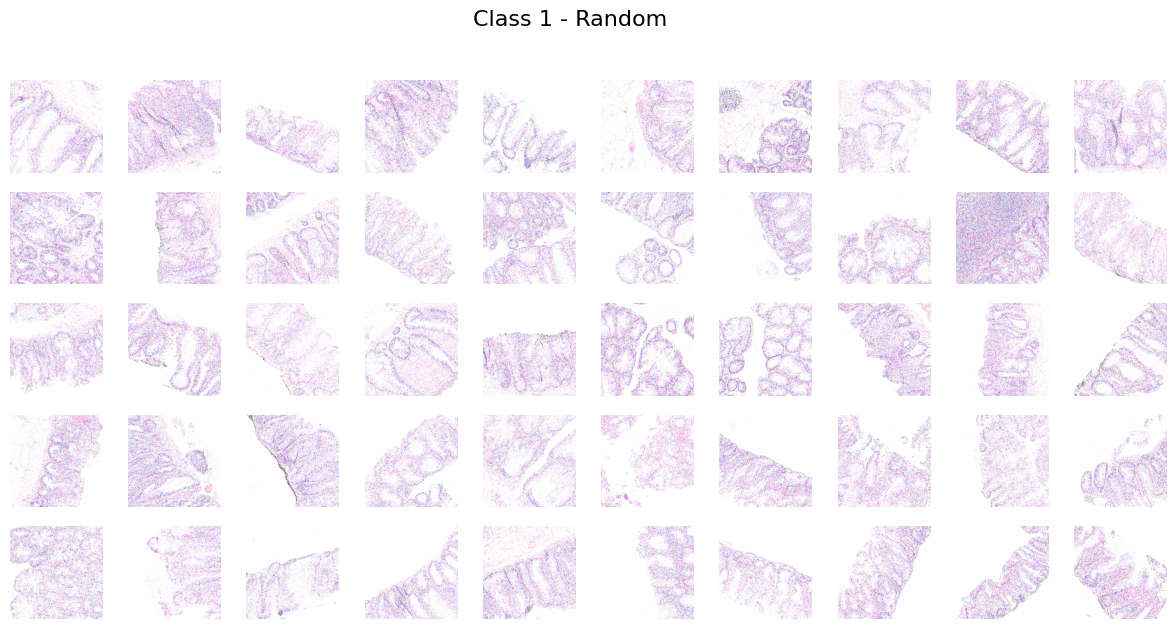

Image grids saved to mhist_result/Random_grid


In [33]:
img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset.pt')
img_syn = img_syn_loaded['images'] 
labels_syn = img_syn_loaded['labels']
print(f"Images shape: {img_syn.shape}")
print(f"Labels shape: {labels_syn.shape}")
display_image_grid(img_syn, labels_syn, noise_type='Random')

In [0]:
# 2d 
def generate_synthetic_dataset_with_noise(real_dataset, num_classes, images_per_class=50, noise_std=0.8):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):
        # Randomly sample 50 images from each class
        indices = random.sample(
            [i for i, (_, label) in enumerate(real_dataset) if label == class_id],
            images_per_class
        )

        for i in indices:
            img_real = real_dataset[i][0]
            noise = torch.normal(mean=0, std=noise_std, size=img_real.shape)

            noise = noise.to(img_real.device)

            synthetic_image = img_real + noise

            synthetic_image = torch.clamp(synthetic_image, 0, 1)

            synthetic_images.append(synthetic_image)
            synthetic_labels.append(real_dataset[i][1])

    # Stack images to return a tensor for training
    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels)

    return img_syn, labels_syn

img_syn, _ = generate_synthetic_dataset_with_noise(real_dataset, num_classes)
img_syn = torch.nn.Parameter(img_syn)
optimizer_img = optim.SGD([img_syn], lr=0.1)  # lr is eta_s

img_syn, losses = train_dataset(img_syn)
save_results(img_syn, losses, 'Gaussian')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14107803..1.1745412].


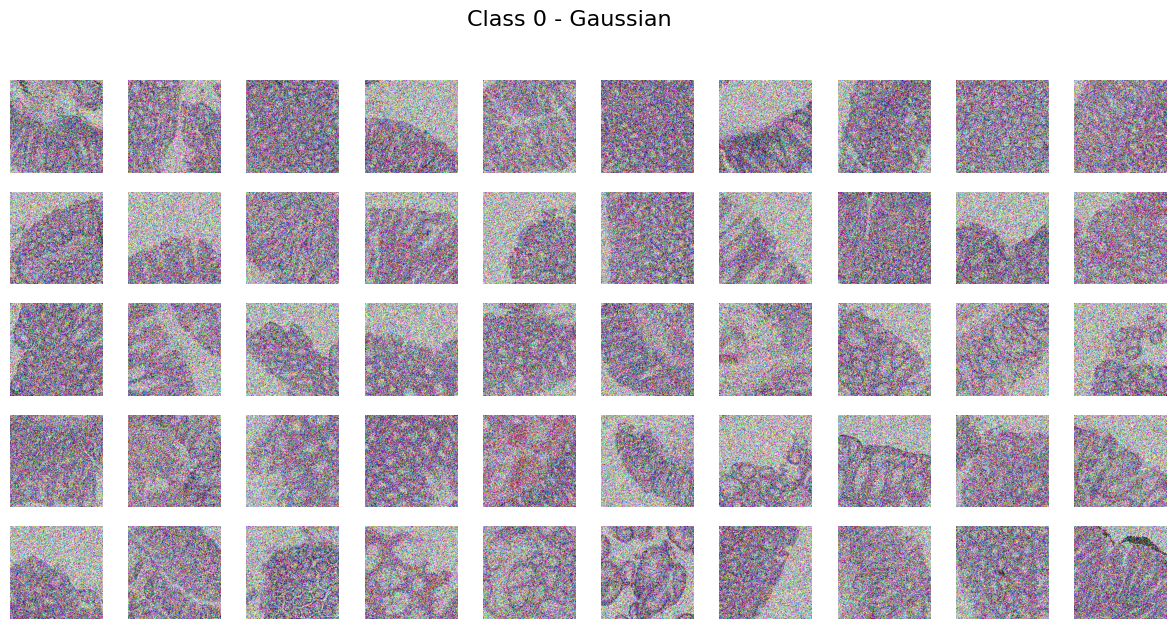

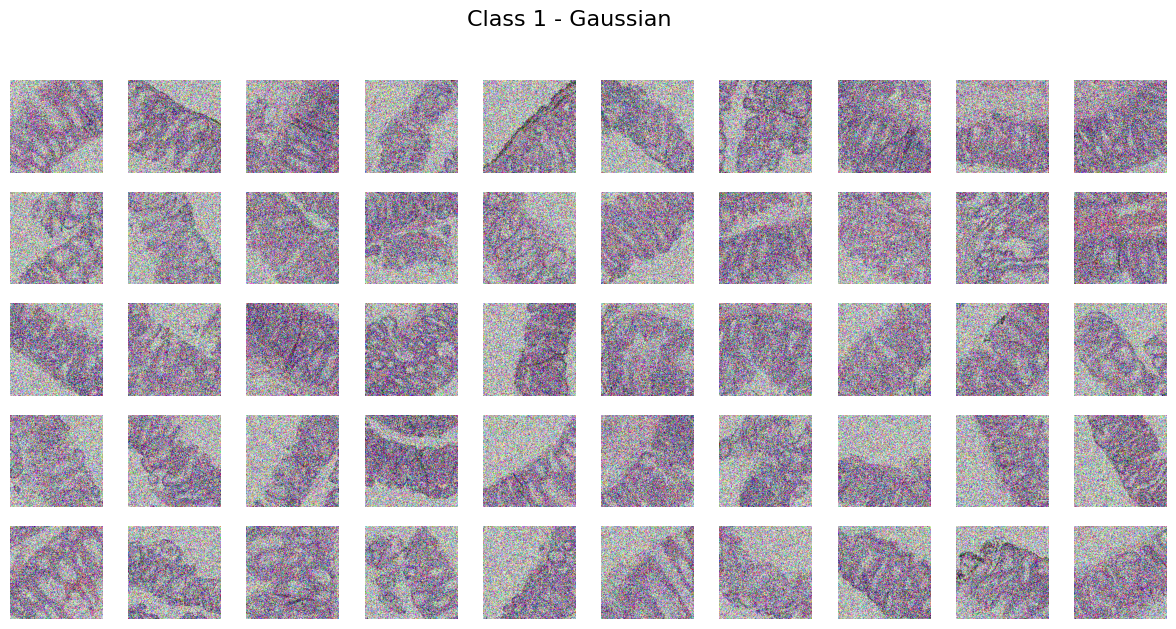

Image grids saved to mhist_result/Gaussian_grid


In [46]:
img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset.pt')
img_syn = img_syn_loaded['images'] 
labels_syn = img_syn_loaded['labels']

display_image_grid(img_syn, labels_syn, noise_type='Gaussian')

##### 2e) Train the model with condensed dataset

In [33]:
random_model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224)) 
random_optimizer = SGD(random_model.parameters(), lr=0.01, momentum=0.9)

gaussian_model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224)) 
gaussian_optimizer = SGD(gaussian_model.parameters(), lr=0.01, momentum=0.9)

random_scheduler = CosineAnnealingLR(random_optimizer, T_max=20)
gaussian_scheduler = CosineAnnealingLR(gaussian_optimizer, T_max=20)

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']  
labels_syn = img_syn_loaded['labels']  

random_synthetic_dataset = TensorDataset(img_syn, labels_syn)

random_train_loader = DataLoader(random_synthetic_dataset, batch_size=32, shuffle=True)

training_model(random_model, random_optimizer, random_scheduler, 
               criterion, random_train_loader)

In [ ]:

img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']  
labels_syn = img_syn_loaded['labels']  

gaussian_synthetic_dataset = TensorDataset(img_syn, labels_syn)

gaussian_train_loader = DataLoader(gaussian_synthetic_dataset, batch_size=32, shuffle=True)

training_model(gaussian_model, gaussian_optimizer, gaussian_scheduler, 
               criterion, gaussian_train_loader)

In [ ]:
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
evaluate_model(random_model, test_loader)

In [ ]:
evaluate_model(gaussian_model, test_loader)

#### 3 Cross-Architecture Generalization

In [43]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512 * 7 * 7, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out

def ResNet18(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes)

In [44]:
random_resnet = ResNet18(channel=3, num_classes=2) 
random_optimizer = SGD(random_resnet.parameters(), lr=0.01, momentum=0.9)
random_resnet.to(device)
gaussian_resnet = ResNet18(channel=3, num_classes=2) 
gaussian_optimizer = SGD(gaussian_resnet.parameters(), lr=0.01, momentum=0.9)
gaussian_resnet.to(device)
random_scheduler = CosineAnnealingLR(random_optimizer, T_max=20)
gaussian_scheduler = CosineAnnealingLR(gaussian_optimizer, T_max=20)

criterion = torch.nn.CrossEntropyLoss()

In [45]:
img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']  
labels_syn = img_syn_loaded['labels']  

random_synthetic_dataset = TensorDataset(img_syn, labels_syn)

random_train_loader = DataLoader(random_synthetic_dataset, batch_size=32, shuffle=True)

training_model(random_resnet, random_optimizer, random_scheduler, 
               criterion, random_train_loader)

Epoch [1/20], Loss: 26.08310546875
Epoch [2/20], Loss: 85.67764892578126
Epoch [3/20], Loss: 60.948695220947265
Epoch [4/20], Loss: 16.561270351409913


KeyboardInterrupt: 

In [ ]:
img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']  
labels_syn = img_syn_loaded['labels']  

gaussian_synthetic_dataset = TensorDataset(img_syn, labels_syn)

gaussian_train_loader = DataLoader(gaussian_synthetic_dataset, batch_size=32, shuffle=True)

training_model(gaussian_resnet, gaussian_optimizer, gaussian_scheduler, 
               criterion, gaussian_train_loader)

In [ ]:
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
evaluate_model(random_resnet, test_loader)

In [ ]:
evaluate_model(gaussian_resnet, test_loader)